Test AR fits to long-term time series of large catchments in two ways:
1. Single set of coefficients, 1850-2203
2. Three separate models, 1850-1999, 2000-2099, 2100-2203

Also plot the SMB catchment means and assess the variance changing in time.

Last updated: 6 Jun 2023 | EHU

In [91]:
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
from sklearn.covariance import GraphicalLassoCV
from statsmodels.tsa.ar_model import AutoReg
import shapefile
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pyproj as pyproj
from scipy import interpolate, optimize
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import time

In [4]:
###------------------------
### DATA READ-IN  AND PROJECTION
###------------------------

## Read in BedMachine grid to reproject SMB
gl_bed_path ='/Volumes/GoogleDrive/My Drive/Greenland-data/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() #x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() #y-coord
ss = fh.variables['surface'][:].copy() # surface elevation
M = fh.variables['mask'][:].copy() ## land cover type mask (2 = grounded ice)
fh.close()

## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Volumes/GoogleDrive/My Drive/Greenland-data/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

Reading in Mouginot catchments


In [5]:
## read in ISMIP6 grid for geometry
print('Reading in ISMIP6 geometry')
# geom_path = '/Users/eultee@middlebury.edu/Documents/Research/data/5km_ISMIP6grid.nc'
geom_path = '/Volumes/GoogleDrive/Other computers/My iMac/Research/data/5km_ISMIP6grid.nc'
fh3 = Dataset(geom_path, mode='r')
x_lon_debm = fh3.variables['lon'][:].copy() # longitude
y_lat_debm = fh3.variables['lat'][:].copy() # latitude
fh3.close()

Reading in ISMIP6 geometry


In [6]:
## dEBM read in for preliminary view
print('Reading in example dEBM field')
# debm_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
# debm_path = '/Volumes/GoogleDrive/Other computers/My iMac/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
debm_path = '/Volumes/GoogleDrive/My Drive/debm_smb_forLizz/'
fh2 = Dataset(debm_path+'dEBM_SMB4Vincent_2007.nc', mode='r')
# x_debm = fh2.dimensions['x'].copy() #x-coord (polar stereo?)
# y_debm = fh2.dimensions['y'].copy() #y-coord 
smb_debm = fh2.variables['SMB'][:].copy()
fh2.close()

Reading in example dEBM field


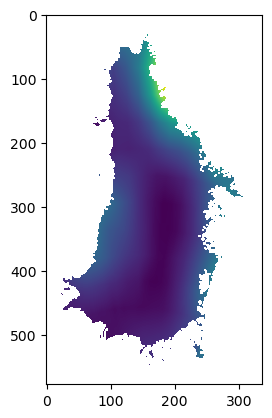

In [7]:
import matplotlib.pyplot as plt
plt.imshow(smb_debm[0])
plt.show()

In [8]:
smb_debm[0].min()

3.756580114364624

In [9]:
###------------------------
### SET UP SMB REPROJECTION
###------------------------

## Down-sample bed topo
x_3km = xx[::20] # sample at ~3 km resolution
y_3km = yy[::20]
s_3km = ss[::20,::20] ## we'll use surface elevation for monthly lapse rate
Xmat, Ymat = np.meshgrid(x_3km, y_3km) # Downsampled BedMachine coords

print('Creating reprojected grid')
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by SMB data
psn_gl = pyproj.Proj("+init=epsg:3413") # Polar Stereographic North used by BedMachine and Mankoff
xs, ys = pyproj.transform(wgs84, psn_gl, x_lon_debm, y_lat_debm)

Creating reprojected grid


/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_50467/1494661919.py:14: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-

In [21]:
###------------------------
### CHOOSE CATCHMENTS
###------------------------
 
## List the Mouginot catchment IDs associated with the glaciers we're testing
catchments = {57: '79N',
              222: 'Petermann Glacier',
              217: 'Sermeq Kujalleq (Jako)', 
              62: 'Helheim Glacier'
             }
catchments.keys()

dict_keys([57, 222, 217, 62])

In [22]:
###------------------------
### CREATE FRAMEWORK
###------------------------

caps_and_disjoint = []

## Perform Delaunay triangulation over each catchment region
tri_ctmts = {i: [] for i in catchments.keys()}
for i in catchments.keys():
    print('Triangulating catchment {}'.format(sf.record(i)['NAME']))
    c = MultiPoint(sf.shape(i).points)
    tris = triangulate(c)
    tri_ctmts[i] = tris
    if 'ICE_CAPS' in sf.record(i)['NAME']:
        caps_and_disjoint.append(i)
    elif len(sf.shape(i).parts)>1:
        caps_and_disjoint.append(i)

Triangulating catchment NIOGHALVFJERDSFJORDEN
Triangulating catchment PETERMANN_GLETSCHER
Triangulating catchment JAKOBSHAVN_ISBRAE
Triangulating catchment HELHEIMGLETSCHER


In [23]:
caps_and_disjoint ## check that none of these are disjoint

[]

## Check total SMB series for full ice sheet

Re-running this to compare with processed data from previous (buggy) dataset, but I don't think it's necessary for the analysis we're doing now.

In [24]:
## Read in every year, check mean, add to series
calib_years = range(2007, 2018)
min_series, max_series, mean_series = [],[],[]

for y in calib_years:
    ## dEBM read in for preliminary view
    print('Reading in dEBM field for {}'.format(y))
    # debm_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
    fh2 = Dataset(debm_path+'dEBM_SMB4Vincent_{}.nc'.format(y), mode='r')
    # x_debm = fh2.dimensions['x'].copy() #x-coord (polar stereo?)
    # y_debm = fh2.dimensions['y'].copy() #y-coord 
    smb_debm = fh2.variables['SMB'][:].copy()
    fh2.close()
    for m in range(0,12):
        min_series.append(smb_debm[m].min())
        max_series.append(smb_debm[m].max())
        mean_series.append(smb_debm[m].mean())

Reading in dEBM field for 2007
Reading in dEBM field for 2008
Reading in dEBM field for 2009
Reading in dEBM field for 2010
Reading in dEBM field for 2011
Reading in dEBM field for 2012
Reading in dEBM field for 2013
Reading in dEBM field for 2014
Reading in dEBM field for 2015
Reading in dEBM field for 2016
Reading in dEBM field for 2017


In [25]:
len(mean_series)

132

In [26]:
tseries = pd.date_range(start='2007-01-01', end='2017-12-31', freq='M')
tseries

DatetimeIndex(['2007-01-31', '2007-02-28', '2007-03-31', '2007-04-30',
               '2007-05-31', '2007-06-30', '2007-07-31', '2007-08-31',
               '2007-09-30', '2007-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=132, freq='M')

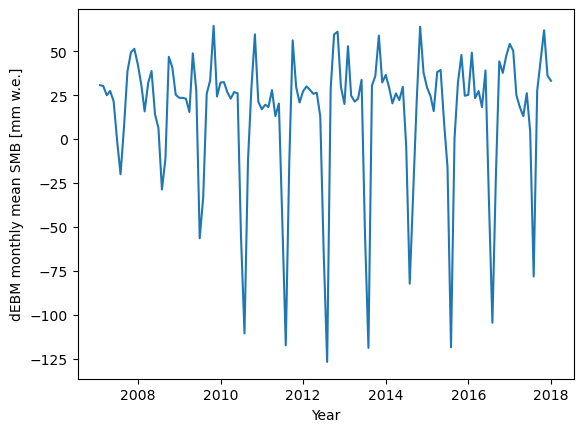

In [27]:
fig, ax = plt.subplots()
ax.plot(tseries,mean_series)
ax.set(xlabel='Year', ylabel='dEBM monthly mean SMB [mm w.e.]')
plt.show()

## Catchment summing

In [31]:
years = range(1850, 2204) ## full period to 2203
start_date = datetime.datetime(years[0],1,1)
end_date = datetime.datetime(years[-1],12,31)
dates = pd.date_range(start=start_date, end=end_date, freq='M')
df_record = pd.DataFrame(columns=[i for i in catchments.keys()], index=dates)
# df_elev_per_ctmt = {i: 
#                     {n: 
#                      {y: pd.DataFrame(columns=('elevation', 
#                                                      'point_smb')) for y in years} for n in range(12)} for i in catchments_to_pull}

In [32]:
###------------------------
### CATCHMENT MEAN FOR FULL PERIOD
###------------------------

t0 = time.time()
for y in years:
    ti = time.time()
    fpath = debm_path+'dEBM_SMB4Vincent_{}.nc'.format(y)
    fh = Dataset(fpath, mode='r')
    smb_m = fh.variables['SMB'][:].copy()
    fh.close()
    d_subset = [d for d in dates if d.year==y]
    for i in range(len(smb_m)): # for each month
        ## interpolate SMB
        smb_ds = smb_m[i]
        regridded_smb = interpolate.griddata((xs.ravel(), ys.ravel()), smb_ds.ravel(), (Xmat, Ymat), method='nearest')
        ## Sample SMB at each Delaunay triangle and sum
        for j in catchments.keys():
            if j in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
                pass
            else:
                catchment_sum = 0
                area_sum = 0
                triangles = tri_ctmts[j]
                for tri in triangles:
                    rep_x, rep_y = tri.representative_point().x, tri.representative_point().y
                    area_m2 = tri.area
                    smb_x = (np.abs(x_3km - rep_x)).argmin()
                    smb_y = (np.abs(y_3km - rep_y)).argmin()
                    nearest_smb = regridded_smb[smb_y, smb_x]
                    if nearest_smb < -9990: ## catch fill values or unrealistic extreme values
                        next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
                        next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
                        next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
                        ### TODO: add an option for a fill value, if next nearest is also bad?
                        local_val = next_nearest_smb*area_m2
    #                 elif nearest_smb > 6000: ## HIRHAM and SNOWMODEL have positive fill val
    #                     next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
    #                     next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
    #                     next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
    #                     ### TODO: add an option for a fill value, if next nearest is also bad?
    #                     local_val = next_nearest_smb*area_m2
                    else:
                        local_val = nearest_smb*area_m2
                    catchment_sum += local_val
                    area_sum += area_m2
                df_record[j][d_subset[i]] = catchment_sum/area_sum
    tf = time.time()
    print('Finished processing year {} in time {}s'.format(y, tf-ti))
t1 = time.time()
print('Finished processing full period in time {}'.format(t1-t0))

## Write to CSV
csv_path = '/Users/lizz/Documents/Research/StISP/{}-test_large_catchments_mean-tseries.csv'.format(datetime.date.today().strftime('%Y%m%d'))
df_record.to_csv(csv_path)
    

Finished processing year 1850 in time 6.514029026031494s
Finished processing year 1851 in time 8.37150263786316s
Finished processing year 1852 in time 7.66577672958374s
Finished processing year 1853 in time 7.863156080245972s
Finished processing year 1854 in time 8.51494312286377s
Finished processing year 1855 in time 8.570777177810669s
Finished processing year 1856 in time 8.07941198348999s
Finished processing year 1857 in time 8.417104959487915s
Finished processing year 1858 in time 8.538029193878174s
Finished processing year 1859 in time 8.573102951049805s
Finished processing year 1860 in time 8.556816101074219s
Finished processing year 1861 in time 8.375190019607544s
Finished processing year 1862 in time 7.917967081069946s
Finished processing year 1863 in time 7.558714866638184s
Finished processing year 1864 in time 8.451089859008789s
Finished processing year 1865 in time 7.830117225646973s
Finished processing year 1866 in time 7.857173919677734s
Finished processing year 1867 in ti

## Inspect the time series

TODO: add a read-in option so that this can be done without all the processing above

Text(0.02, 0.5, 'Annual catchment-mean SMB [mm w.e.]')

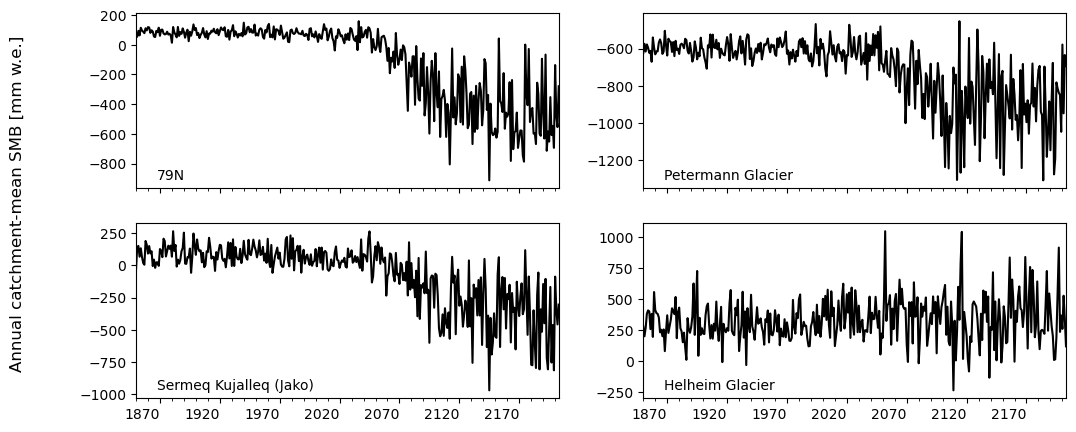

In [90]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2,2, figsize=(12,5), sharex=True)
for i, gid in enumerate(catchments.keys()):
    ax = axs.ravel()[i]
    ax.xaxis.set_major_locator(mdates.YearLocator(50, month=1, day=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(10))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

    df_record[gid].resample('A').sum().plot(ax=ax, color='k')
    ax.text(0.05, 0.05, catchments[gid], transform=ax.transAxes)
    
fig.supylabel('Annual catchment-mean SMB [mm w.e.]')

## AR fits
Examine two ways of fitting AR model: over entire period, or over 3 sub-periods.  We want to know whether the AR structure changes over time or only the amplitude of the variability.

### One fit to full period

In [171]:
def fit_catchment_series_debm(tseries, comparison_n=range(1,6), 
                         seasonal=True, is_anomaly=False, output_params=True):
    """ Modified version of fit_catchment_series
    This one takes a single-model input (dEBM) which is a monthly Series
    is_anomaly: set whether you've already removed the mean
    
    Returns:
        best_n : int, the order of the best fit AutoReg result
    """
    bic_per_n = pd.Series(index=comparison_n, dtype=int)
    if not is_anomaly:
        s = tseries - tseries.mean() ## make this into an anomaly series
    else:
        s = tseries
    
    a = s.resample('A').sum().astype(float)
    
    for n in comparison_n:
            mod = AutoReg(np.asarray(a), n, trend='ct', seasonal=seasonal)
            results = mod.fit()
            bic_per_n[n] = results.bic
    best_n = bic_per_n.idxmin() ## find the BIC-minimizing model
    bic_difference = bic_per_n.transform(lambda x: x-x.min())
    
    if output_params:
        params_out = AutoReg(np.asarray(a), best_n, trend='ct', seasonal=seasonal).fit().params
        return best_n, bic_difference, params_out
    else:
        return best_n, bic_difference

def find_AR_residuals(tseries, which_model, chosen_n=1, 
                         seasonal=False):
    mod = AutoReg(tseries[which_model], chosen_n, trend='ct', seasonal=seasonal)
    results = mod.fit()
    resids = results.resid
    
    return resids

In [184]:
ctmt_mods = {}
bd_all = {}
for gid in catchments.keys():
    s_raw = df_record[gid]
    # s = s_raw - s_raw.mean() ## anomaly series
    # a = s.resample('A').sum()  ## comment these two actions out because fit_catchment_series_debm will do them
    best_n, bd, output_params = fit_catchment_series_debm(s_raw, seasonal=False, output_params=True)
    ctmt_mods[gid] = output_params
    bd_all[gid] = bd

In [185]:
bd_all

{57: 1    119.088967
 2     74.980175
 3     32.520693
 4      6.790754
 5      0.000000
 dtype: float64,
 222: 1    73.220725
 2    65.721897
 3    27.368505
 4    13.322958
 5     0.000000
 dtype: float64,
 217: 1    87.995396
 2    55.715953
 3    42.042509
 4     7.161500
 5     0.000000
 dtype: float64,
 62: 1    30.093528
 2    23.411094
 3    16.969382
 4     8.778749
 5     0.000000
 dtype: float64}

In [166]:
ctmt_mods

{57: array([ 8.00855819e+01, -4.66607984e-01,  6.88548027e-02,  1.60656031e-01,
         2.63903599e-01,  2.30226813e-01,  5.69839444e-02]),
 222: array([ 8.31079651e+01, -4.70941615e-01,  3.81555193e-02, -1.58178900e-02,
         2.79421747e-01,  1.44033171e-01,  1.49334522e-01]),
 217: array([ 1.15161698e+02, -6.56160180e-01,  1.05434215e-01,  1.77968495e-01,
         1.16547539e-01,  2.86486300e-01, -5.81232232e-02]),
 62: array([-4.16405244e+01,  2.32890751e-01,  5.83731621e-02,  1.74557395e-02,
         2.39632932e-02, -6.25371094e-02, -7.66266753e-02])}

In [167]:
cm = pd.DataFrame.from_dict(ctmt_mods, orient='index') ## we can do this because they are all best fit by AR(5)
cm.columns = (['Const', 'trend', 'y1', 'y2', 'y3', 'y4', 'y5'])
cm

,Const,trend,y1,y2,y3,y4,y5
57,80.085582,-0.466608,0.068855,0.160656,0.263904,0.230227,0.056984
222,83.107965,-0.470942,0.038156,-0.015818,0.279422,0.144033,0.149335
217,115.161698,-0.656160,0.105434,0.177968,0.116548,0.286486,-0.058123
62,-41.640524,0.232891,0.058373,0.017456,0.023963,-0.062537,-0.076627


### Three sub-periods
Split the initial input period into three sub-periods and fit them all separately.

In [160]:
df_early = df_record[pd.to_datetime('1850'):pd.to_datetime('2000')]
df_mid = df_record[pd.to_datetime('2000'):pd.to_datetime('2100')]
df_late = df_record[pd.to_datetime('2100'):pd.to_datetime('2204')]

In [168]:
# ctmt_mods_early = {}
# ctmt_mods_mid = {}
# ctmt_mods_late = {}
periods = ['early', 'mid', 'late']
ctmt_mods_sub = dict.fromkeys(periods)

In [174]:
for i, d in enumerate([df_early, df_mid, df_late]):
    k = periods[i]
    ctmt_mods_sub[k] = {}
    for gid in catchments.keys():
        s_raw_sub = d[gid]
        _, _, output_params_e = fit_catchment_series_debm(s_raw_sub, seasonal=False, output_params=True);
        ctmt_mods_sub[k][gid] = output_params_e

In [177]:
ctmt_mods_sub['late']

{57: array([ 5.57082178e+01, -1.11687802e+00, -7.44507570e-02,  1.10440867e-02,
         7.81005119e-02,  5.86687914e-02, -6.83494386e-02]),
 222: array([ 0.90012433,  0.07858298, -0.13337504, -0.1889016 ,  0.18348944,
         0.05452906,  0.09783526]),
 217: array([ 5.82725062e+01, -1.08420663e+00,  5.07904131e-03,  6.09790397e-02,
         8.04389006e-02,  2.01026919e-01, -1.83345629e-01]),
 62: array([-6.74985999e+01,  1.12773477e+00,  8.26290885e-02, -3.09972790e-02,
        -2.54798499e-04, -8.61796705e-02, -1.74490237e-01])}

In [180]:
cm_e = pd.DataFrame.from_dict(ctmt_mods_sub['early'], orient='index') ## period 1850-1999
cm_e.columns = (['Const', 'trend', 'y1', 'y2', 'y3', 'y4', 'y5'])
cm_e

,Const,trend,y1,y2,y3,y4,y5
57,5.472869,-0.067610,0.003666,-0.033846,-0.023423,0.033785,-0.119749
222,5.489647,-0.071321,0.103575,0.028620,-0.140462,0.077646,-0.091208
217,13.458231,-0.171264,0.010658,0.069478,-0.041485,-0.031971,-0.093175
62,19.190680,-0.251553,-0.015239,0.050981,-0.015275,-0.036740,0.020888


In [182]:
cm_m = pd.DataFrame.from_dict(ctmt_mods_sub['mid'], orient='index') ## period 2000-2099
cm_m.columns = (['Const', 'trend', 'y1', 'y2', 'y3', 'y4', 'y5'])
cm_m

,Const,trend,y1,y2,y3,y4,y5
57,120.746182,-2.411858,0.112665,-0.010477,0.154163,0.327517,-0.104779
222,137.663774,-2.642189,0.102352,-0.003382,-0.065725,0.050244,0.062009
217,88.449600,-1.791611,0.048904,0.212954,-0.213067,0.242141,0.119596
62,-7.341552,0.037841,-0.052257,-0.061749,0.009097,-0.107785,-0.067605


In [183]:
cm_l = pd.DataFrame.from_dict(ctmt_mods_sub['late'], orient='index') ## period 2100-2203
cm_l.columns = (['Const', 'trend', 'y1', 'y2', 'y3', 'y4', 'y5'])
cm_l

,Const,trend,y1,y2,y3,y4,y5
57,55.708218,-1.116878,-0.074451,0.011044,0.078101,0.058669,-0.068349
222,0.900124,0.078583,-0.133375,-0.188902,0.183489,0.054529,0.097835
217,58.272506,-1.084207,0.005079,0.060979,0.080439,0.201027,-0.183346
62,-67.498600,1.127735,0.082629,-0.030997,-0.000255,-0.086180,-0.174490


## Does structure change over the period?
The best fit to dEBM output for the full period and for each sub-period tested above is an AR(5) type model.  This is different from what we have seen with GrSMBMIP output.  To force StISSM, we want to know whether we can use one AR model for the full period or whether the structure changes such that we need separately defined models for each sub-period.

### ACF and PACF for full period

Text(0.5, 0.01, 'Lag [yr]')

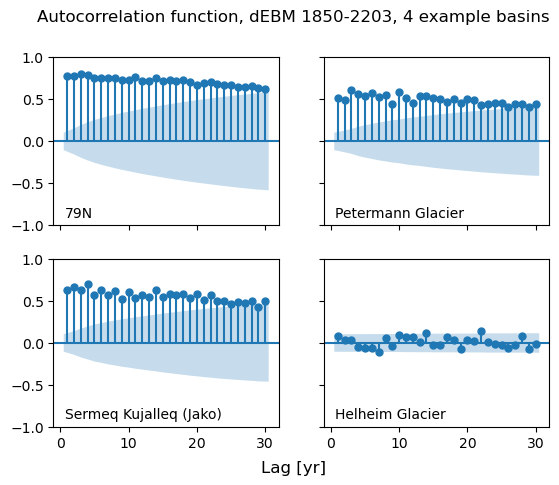

In [198]:
## compute the ACF and PACF for full period
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
for i, gid in enumerate(catchments.keys()):
    ax = axs.ravel()[i]
    s_raw = df_record[gid]
    s = s_raw - s_raw.mean() ## anomaly series
    a = s.resample('A').sum()
    plot_acf(a, ax=ax, lags=30, zero=False)
    ax.set(title='', )
    ax.text(0.05, 0.05, catchments[gid], transform=ax.transAxes)
fig.suptitle('Autocorrelation function, dEBM 1850-2203, 4 example basins')
fig.supxlabel('Lag [yr]')

/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warn

Text(0.5, 0.01, 'Lag [yr]')

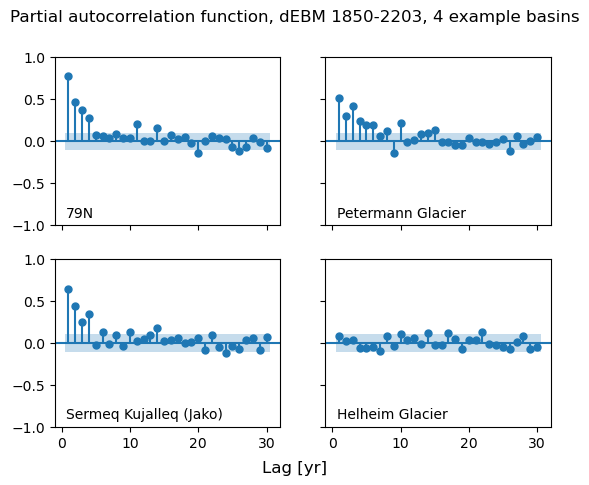

In [199]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
for i, gid in enumerate(catchments.keys()):
    ax = axs.ravel()[i]
    s_raw = df_record[gid]
    s = s_raw - s_raw.mean() ## anomaly series
    a = s.resample('A').sum()
    plot_pacf(a, ax=ax, lags=30, zero=False)
    ax.set(title='', )
    ax.text(0.05, 0.05, catchments[gid], transform=ax.transAxes)
fig.suptitle('Partial autocorrelation function, dEBM 1850-2203, 4 example basins')
fig.supxlabel('Lag [yr]')

### ACF and PACF for sub-periods

Text(0.5, 0.01, 'Lag [yr]')

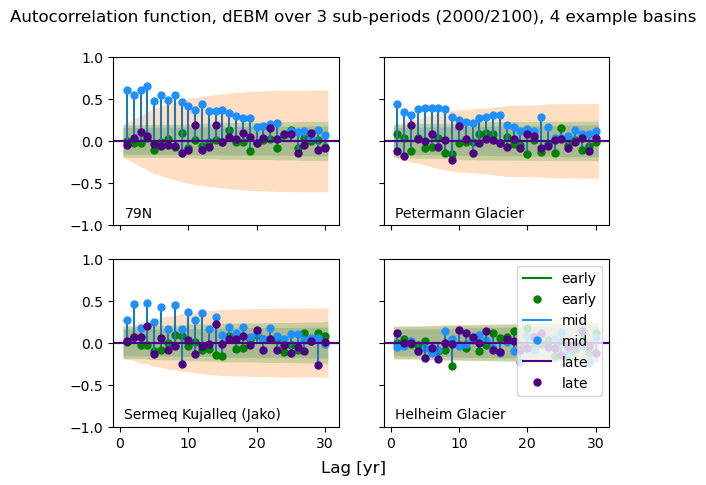

In [212]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

colors = ['green', 'dodgerblue', 'indigo']

for j, gid in enumerate(catchments.keys()):
    ax = axs.ravel()[j]
    for i, d in enumerate([df_early, df_mid, df_late]):
        k = periods[i]
        ctmt_mods_sub[k] = {}
        s_raw_sub = d[gid]
        s = s_raw_sub - s_raw_sub.mean() ## anomaly series
        a = s.resample('A').sum()
        plot_acf(a, ax=ax, lags=30, zero=False, 
                  title=None, color=colors[i], label=k)   
    ax.text(0.05, 0.05, catchments[gid], transform=ax.transAxes)
    if j==3:
        ax.legend(loc='best')
fig.suptitle('Autocorrelation function, dEBM over 3 sub-periods (2000/2100), 4 example basins')
fig.supxlabel('Lag [yr]')

/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warn

Text(0.5, 0.01, 'Lag [yr]')

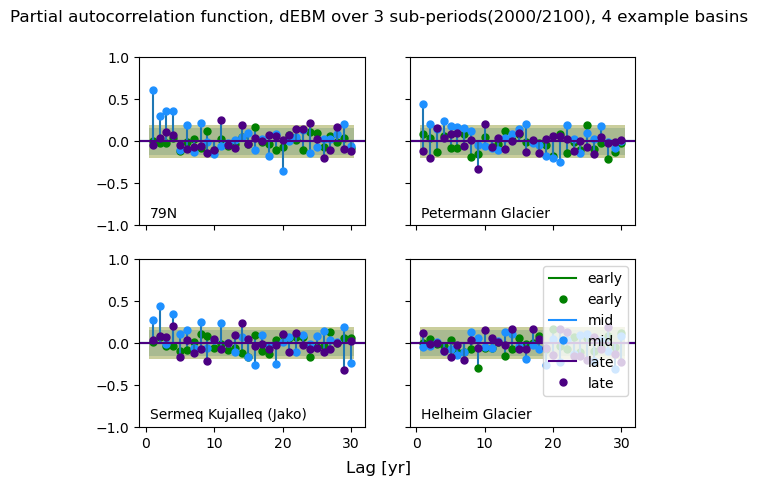

In [213]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

colors = ['green', 'dodgerblue', 'indigo']

for j, gid in enumerate(catchments.keys()):
    ax = axs.ravel()[j]
    for i, d in enumerate([df_early, df_mid, df_late]):
        k = periods[i]
        ctmt_mods_sub[k] = {}
        s_raw_sub = d[gid]
        s = s_raw_sub - s_raw_sub.mean() ## anomaly series
        a = s.resample('A').sum()
        plot_pacf(a, ax=ax, lags=30, zero=False, 
                  title=None, color=colors[i], label=k)   
    ax.text(0.05, 0.05, catchments[gid], transform=ax.transAxes)
    if j==3:
        ax.legend(loc='best')
fig.suptitle('Partial autocorrelation function, dEBM over 3 sub-periods(2000/2100), 4 example basins')
fig.supxlabel('Lag [yr]')

In [ ]:
## TODO: re-process with break points in 2000, 2050, 2100 as discussed